In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pykep
import random
from scipy.optimize import newton

In [4]:
def get_period(a, mu = 398600):
    """`
    return the period in seconds
    a needs to be in km
    """
    return (2*np.pi*a**1.5)/mu**0.5

def kepler(E, M_e, e):
    """Kepler's equation, to be used in a Newton solver."""
    return E - e * np.sin(E) - M_e

def d_kepler_d_E(E, M_e, e):
    """The derivative of Kepler's equation, to be used in a Newton solver.
    
    Note that the argument M_e is unused, but must be present so the function
    arguments are consistent with the kepler function.
    """
    return 1 - e * np.cos(E)

def orbit(elements, t):
    """
    Gives the posistion and velocity vectors at time t (since perigee).
    The elements input needs to be a list of Kepler elements as given by pykep package.
    Only a and e are required for this stage.
    """
    T = get_period(elements[0])
    e = elements[1]
    M_e = 2 * np.pi * t/T
    E = newton(func=kepler, fprime=d_kepler_d_E, x0=np.pi, args=(M_e, e))
    elements[5] = E
    r,v = pykep.par2ic(elements, mu=398600)
    r = np.array(r)
    v = np.array(v)
    return r,v

In [5]:
def L_meas(elementsO, rel_vector, t):
    """
    Give the unit vector between the known observer orbit and the relative vector
    between the target and observer vector. 
    """
    rO, vO = orbit(elementsO, t)
    rO = np.array(rO)
    rel = rO - rel_vector
    return rel/np.linalg.norm(rel)

def L_between_orbits(elementsO, elementsT, t):
    """
    Give the unit vector between two orbits defined by Kepler elements.
    Only a and e are required for this stage
    This will be used to generate "measured" data.
    """
    rO, vO = orbit(elementsO, t)
    rT, vT = orbit(elementsT, t)
    rO = np.array(rO)
    rT = np.array(rT)
    rel = rO - rT
    return rel/np.linalg.norm(rel)

In [6]:
def mutation(population, no_of_outputs):
    """
    Population is a list.
    Input how many extra chromoses are wanted.
    """
    stnd_dev = 10  # may change. In the paper they used 10
    for i in range(no_of_outputs):
        index = random.randint(0, len(population) - 1)
        rho0, rho1 = population[index]
        rho0_new = rho0 + stnd_dev
        rho1_new = rho1 + stnd_dev
        population.append([rho0_new, rho1_new])
    return population

In [7]:
def crossover(point1, point2, D):
    point1[1] = point2[1]
    point2[1] = point1[1]

    if abs(point1[0] - point1[1]) < D:
        if np.random.randint(0,1) == 1:
            return point1
        else:
            return point2
    else:
        return False

In [8]:
def get_target_r(elementsO, elementsT, point, t):
    # initial "measurment" and orbit
    rho_i = point[0]
    rO_i = orbit(elementsO, 0)[0]
    L_t0 = L_between_orbits(elementsO, elementsT, 0)
    rT_i = rho_i*L_t0 + rO_i
    # final "measurment" and orbit
    rho_f = point[1]
    rO_f = orbit(elementsO, t)[0]
    L_tf = L_between_orbits(elementsO, elementsT, t)
    rT_f = rho_f*L_tf + rO_f

    return rT_i, rT_f

def solve_lambert(r1, r2, tof):
    """
    r1 and r2 are vectors (np arrays)
    """
    # convert np array to list for pykep package
    rT_i_list = np.ndarray.tolist(r1)  
    rT_f_list = np.ndarray.tolist(r2)
    # solve Lambert's problem
    l = pykep.lambert_problem(r1 = rT_i_list, r2 = rT_f_list, tof = tof, mu=398600, cw=True)
    # convert results
    vi = l.get_v1()[0]  # get the velocity vector at initial time for one revolution
    elements = pykep.ic2par(rT_i_list,vi, mu=398600)  # get Kepler elements from pos and vel vectors
    return elements

In [9]:
def fitness(elementsO, elementsT, estimated_orbit, no_of_measurments = 60):
    """
    For now it compares against the ideal.
    """
    fit = 1
    for t in range(no_of_measurments):
        L_ideal = L_between_orbits(elementsO, elementsT, t)  
        L_ast = L_between_orbits(elementsO, estimated_orbit, t)
        fit = fit * np.dot(L_ideal, L_ast)
    return fit

def objective_func(elementsO, elementsT, estimated_orbits, population):
    """
    Runs the fitness function on all points.
    Saves the point with the corresponding fitness value   
    """
    index = 0
    fit_values = []
    for orbit in estimated_orbits:
        fit_value = fitness(elementsO, elementsT, orbit)
        fit_values.append(fit_value)
    return fit_values


In [10]:
def evaluate_D(elementsO, TOF):
    mu = 398600  # km^3/s^2. Make into a global variable later. Can I make TOF a global variable?
    aO = elementsO[0]
    eO = elementsO[1]
    aT_max = 50000

    # some calculations
    rO_perigee = (1-eO)*aO
    vO_perigee = ((1+eO)/(1-eO) * mu/aO)**0.5
    vT_perigee_max = (2*mu/rO_perigee*(1-rO_perigee/(2*aT_max)))**0.5

    return (vO_perigee + vT_perigee_max)*TOF, rO_perigee

In [11]:
def grid_between_lines(D, height=9000, width=9000):
    distances = []  # a list that will contain the whole population points (rho_i, rho_f)
    A = height*width
    A_s = A - (height-D)*width/2 - (height-2*D)*(width-D)/2
    no_of_nodes = 1000*A/A_s  # no of nodes in the 9000x9000 (height x width) rectangle

    xs = np.linspace(0, width, int((no_of_nodes)**0.5)) # create values for rho_i
    ys = np.linspace(0, height, int((no_of_nodes)**0.5)) # create values for rho_f
    
    for x in xs:
        for y in ys:
            if y < (x + D) and y > (x - D):
                distances.append([x,y])  # only add points that are between the lines

    #plt.plot(xc, yc, '.r')
    #plt.show()
    
    return distances

In [12]:
def constraints(elements, rO_perigee):
    """
    Return true if satisfied.
    """
    a = elements[0]
    e = elements[1]
    R_earth = 6371 # km
    
    if R_earth + 200 <= a and a <= 50000 and 0 <= e and e <= 1 - rO_perigee/50000: # aT_max = 50000 km
        return True
    else:
        return False

In [13]:
def mean(population):
    n = len(population)
    sum_i = 0
    sum_f = 0
    for point in population:
        sum_i += point[0]
        sum_f += point[1]
    return sum_i/n, sum_f/n    

def covariance_matrix(population):
    """
    Returns the standard deviations of the population in terms of two variables.
    Our points consist of initial and final distance.
    """
    c11 = 0
    c12 = 0
    c22 = 0
    mean_i, mean_f = mean(population)
    n = len(population)
    for point in population:
        c11 += (point[0]-mean_i)**2
        c12 += (point[0]-mean_i)*(point[1]-mean_f)
        c22 += (point[1]-mean_f)**2
    return (c11/n)**0.5, (c22/n)**0.5, (c12/n)**0.5

def last_similarity(value1,value2, list, error = 0):
    """
    Input is the new value to be compared and a list consisting of the previous points.
    The input list should be a list (2x2) in a list of length phi.
    """
    list.remove(0)  # remove first element
    list.append((value1,value2))  # add the new element to the list

    for point in list:
        last_value1, last_value2 = point
        difference1 = abs(last_value1 - value1)
        difference2 = abs(last_value2 - value2)
        if difference1 < error and difference2 < error:
            continue
        else:
            return False, list  # is not similar
    return True, list  # is similar
    


def stop_criteria(population, last_means, best_values, last_best_values, no_of_gens,lim_O = 5, lim_F = 5, max_gen=30,error = 0):
    mean_I, mean_F = mean(population)
    best_I, best_F = best_values
    """
    Returns True if met.
    """
    # for means
    means_sim, means_sim_list = last_similarity(mean_I, mean_F, last_means)
    # for best values
    best_sim, best_sim_list = last_similarity(best_I, best_F, last_best_values)
    # standard values
    sigma_OO, sigma_FF, sigma_OF = covariance_matrix(population)

    if means_sim == True or best_sim == True:
        return True, None, None
    if no_of_gens > max_gen:
        return True
    if sigma_OO < lim_O and sigma_FF < lim_F:
        return True, None, None
    
    else:
        return False, means_sim_list, best_sim_list  # need these values for the next iteration

In [14]:
def show_pop(population):
    xs = [x[0] for x in population]
    ys = [x[1] for x in population]
    plt.plot(xs, ys, '.k')
    plt.show()

In [18]:
def Lambert_problem(population, orbits, elementsO, elementsT, point, rO_perigee, TOF):
    # Set up Lambert's problem
    rT_i, rT_f = get_target_r(elementsO,elementsT, point, TOF)
    # solve Lambert's problem
    elementsT_estimated = list(solve_lambert(r1 = rT_i, r2 = rT_f, tof = TOF))
    if constraints(elementsT_estimated, rO_perigee) is True:
        orbits.append(elementsT_estimated)
        population.append(point)
    
    return population, orbits

In [62]:
def initialise_pop(elementsO, elementsT, TOF=60):
    """
    Initialises the population.
    Returns the population along with the orbits.
    """
    D, rO_perigee = evaluate_D(elementsO, TOF)
    # get an evenly spaced grid between two lines Rho in the range [0,9000]
    original_population = grid_between_lines(D)  # initial population
    orbits = []
    population = []
    
    for point in original_population:
        population, orbits = Lambert_problem(population, orbits, elementsO, elementsT, point, rO_perigee, TOF)
    
    n = len(population)
    if len(population) > 1000:
        # remove the number of extra points randomly
        no_of_extra_points = len(population) - 1000
        for i in range(no_of_extra_points):
            index = random.randint(0, len(population))
            popped = population.pop(index)  # have to remove the points
            orbits.pop(index)  # remove the corresponding orbit

    if len(population) < 1000:
        # gain extra points via mutation
        no_of_extra_points = 1000 - len(population)
        population_new = mutation(population, no_of_extra_points)  # for new points I have to solve for the orbit again
        for point in population_new[n:]:
            p, orbits = Lambert_problem([], orbits, elementsO, elementsT, point, rO_perigee, TOF)
        population = population_new  # to avoid confusion
        
    return population, orbits

In [80]:
def get_elite(values, population, n=100):
    sorted_values = values
    sorted_values.sort(reverse=True)
    pop_elite = []
    
    for value in sorted_values[:100]:
        index = values.index(value)
        pop_elite.append(population[index])
    
    return pop_elite, sorted_values[:100]

I think it worked


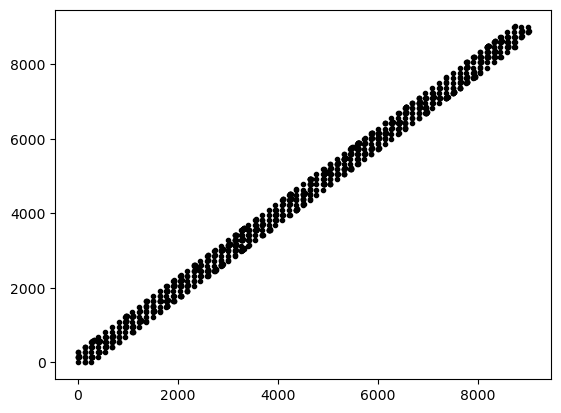

In [72]:
elements_deb = [7100,0.0043,np.radians(98.289),np.radians(49.866),np.radians(356.768),0]
elements_sat = [7133.8,0.0043,np.radians(98.289),np.radians(49.866),np.radians(356.768),0]

# initialise
pop, orbits = initialise_pop(elements_sat, elements_deb)
show_pop(pop)

In [ ]:
fit_values = objective_func(elements_sat, elements_deb, orbits, pop)

In [81]:
elite = get_elite(fit_values, pop)


1000
100
100


In [ ]:
while 

In [21]:
elements = [5901.149278552159, 1.4477471563854718, 1.7154666684926894, 0.8703258847994934, 4.594129890838893, 0.8540083184421274]
constraints(elements, 7102.85)

False

In [77]:
l = [12,3,6,34,7]

IndexError: pop index out of range

In [74]:
l = ([1,2,3], [2,6,8])

for x in l:
    print(x)

[1, 2, 3]
[2, 6, 8]


In [45]:
a = (1,2,3,4)
a = list(a)
l = []
l.append(a)
l

[[1, 2, 3, 4]]

In [22]:
for i in range(3):
    print(i)

0
1
2
